# Melanoma classification with PyTorch Lightning

Using EfficientNet on PyTorch Lightning, with its amazing hardware agnostic and mixed precision implementation.

This is still work in progress, so please bear with me

In [1]:
fold_number = 0
tta   = 20

batch_size = {
    'tpu': 10, # x8
    'gpu': 20, # 10 without AMP
    'cpu': 4,
}

arch = 'efficientnet-b5'
resolution = 456  # orignal res for B5
input_res  = 512

lr = 8e-6   # * batch_size
weight_decay = 2e-5
pos_weight   = 3.2
label_smoothing = 0.03

max_epochs = 7

In [2]:
batch_size = batch_size['gpu']

# Install modules

Update PyTorch to enable its native support to Mixed Precision or XLA for TPU

In [3]:
%reload_ext autoreload
%autoreload 2

# Hardware lookup

In [4]:
import os
import torch

num_workers = os.cpu_count()
gpus = 1 if torch.cuda.is_available() else None

try:
    import torch_xla.core.xla_model as xm
    tpu_cores = 8 #xm.xrt_world_size()
except:
    tpu_cores = None

In [6]:
if isinstance(batch_size, dict):
    if tpu_cores:
        batch_size = batch_size['tpu']
        lr *= tpu_cores
        num_workers = 1
    elif gpus:
        batch_size = batch_size['gpu']
        # support for free Colab GPU's
        if 'K80' in torch.cuda.get_device_name():
            batch_size = batch_size//3
        elif 'T4' in torch.cuda.get_device_name():
            batch_size = int(batch_size * 0.66)
    else:
        batch_size = batch_size['cpu']

lr *= batch_size

dict(
    num_workers=num_workers,
    tpu_cores=tpu_cores,
    gpus=gpus,
    batch_size=batch_size,
    lr=lr,
)

{'batch_size': 22,
 'gpus': 1,
 'lr': 0.000176,
 'num_workers': 4,
 'tpu_cores': None}

# Automatic Mixed Precision

NVIDIA Apex is required only prior to PyTorch 1.6

In [5]:
# check for torch's native mixed precision support (pt1.6+)
if gpus and not hasattr(torch.cuda, "amp"):
    try:
        from apex import amp
    except:
        !git clone https://github.com/NVIDIA/apex  nv_apex
        !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./nv_apex
        from apex import amp
    # with PyTorch Lightning all you need to do now is set precision=16

# Imports

In [17]:
import os
import time
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage import io
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader


from glob import glob
import sklearn

import pytorch_lightning as pl
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from dataset import load_datasets
from utils import get_train_transforms, get_valid_transforms, get_tta_transforms
from data import *
from pathlib import Path
from fastprogress import progress_bar as tqdm
SAVE_DIR = OUT / f'pl/fold_{fold_number}'
SAVE_DIR.mkdir(exist_ok=True, parents=True)

In [19]:
df_test = pd.read_csv(f"{DATA}/test.csv", index_col="image_name")
ds_train, ds_val, ds_test = load_datasets(fold_number)

# Model

In [10]:
from efficientnet_pytorch import EfficientNet
from pytorch_lightning.metrics.classification import AUROC
from sklearn.metrics import roc_auc_score

class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EfficientNet.from_pretrained(arch, advprop=True)
        self.net._fc = nn.Linear(in_features=self.net._fc.in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            max_lr=lr,
            epochs=max_epochs,
            optimizer=optimizer,
            steps_per_epoch=int(len(ds_train) / batch_size),
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            base_momentum=0.90,
            max_momentum=0.95,
        )
        return [optimizer], [scheduler]

    def step(self, batch):
        # return batch loss
        x, y  = batch
        y_hat = self(x).flatten()
        y_smo = y.float() * (1 - label_smoothing) + 0.5 * label_smoothing
        loss  = F.binary_cross_entropy_with_logits(y_hat, y_smo.type_as(y_hat),
                                                   pos_weight=torch.tensor(pos_weight))
        return loss, y, y_hat.sigmoid()

    def training_step(self, batch, batch_nb):
        # hardware agnostic training
        loss, y, y_hat = self.step(batch)
        acc = (y_hat.round() == y).float().mean().item()
        tensorboard_logs = {'train_loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        loss, y, y_hat = self.step(batch)
        return {'val_loss': loss,
                'y': y.detach(), 'y_hat': y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        auc = AUROC()(pred=y_hat, target=y) if y.float().mean() > 0 else 0.5 # skip sanity check
        acc = (y_hat.round() == y).float().mean().item()
        print(f"Epoch {self.current_epoch} acc:{acc} auc:{auc}")
        tensorboard_logs = {'val_loss': avg_loss, 'val_auc': auc, 'val_acc': acc}
        return {'avg_val_loss': avg_loss,
                'val_auc': auc, 'val_acc': acc,
                'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        x, _ = batch
        y_hat = self(x).flatten().sigmoid()
        return {'y_hat': y_hat}

    def test_epoch_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        assert len(df_test) == len(y_hat), f"{len(df_test)} != {len(y_hat)}"
        df_test['target'] = y_hat.tolist()
        N = len(glob(SAVE_DIR / 'submission*.csv'))
        df_test.target.to_csv(SAVE_DIR / f'submission{N}.csv')
        return {'tta': N}

    def train_dataloader(self):
        return DataLoader(ds_train, batch_size=batch_size, num_workers=num_workers,
                          drop_last=True, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(ds_val, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(ds_test, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=False)

In [ ]:
for fold in range(5):
    SAVE_DIR = OUT / f'pl/fold_{fold}'
    checkpoint = sorted(list(SAVE_DIR.iterdir()), key=lambda x: float(x.stem.split('_')[-1]))[-1]
    model = Model().load_from_checkpoint(str(checkpoint))
    for _ in range(tta):
        

    

In [14]:
trainer = pl.Trainer(default_root_dir=str(SAVE_DIR),
                     tpu_cores=tpu_cores,
                     gpus=gpus,
                     precision=16 if gpus else 32,
                     max_epochs=max_epochs)                        

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


# Submission
Infer on test set using a simple random TTA (test-time augmentation)

In [20]:
for _ in tqdm(range(tta), total=tta):
     trainer.test(model)

--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 0}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 1}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 2}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 3}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 4}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 5}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 6}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 7}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 8}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 9}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 10}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 11}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 12}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 13}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 14}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 15}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 16}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 17}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 18}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
TEST RESULTS
{'tta': 19}
--------------------------------------------------------------------------------



count    10982.000000
mean         0.090776
std          0.132495
min          0.000000
25%          0.025434
50%          0.045038
75%          0.093338
max          1.000000
Name: target, dtype: float64

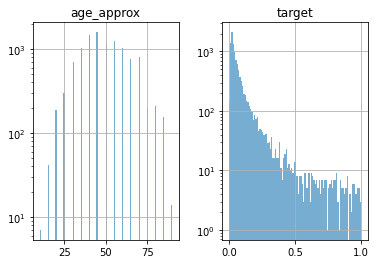

In [29]:
# merge TTA
submission = df_test.copy() 
submission['target'] = 0.0
for sub in glob(f'{SAVE_DIR}/submission*.csv'):
    submission['target'] += pd.read_csv(sub, index_col='image_name').target.fillna(0).values
    # if targets.isna().any():
        # Path(sub).unlink()
        # continue
    # submission['target'] += targets.values

# min-max norm
submission['target'] -= submission.target.min()
submission['target'] /= submission.target.max()

submission.hist(bins=100, log=True, alpha=0.6)
submission.target.describe()

In [30]:
submission.reset_index()[['image_name', 'target']].to_csv(f'{SAVE_DIR}/submission_fold{fold_number}.csv', index=False)

In [31]:
submission.head()

,patient_id,sex,age_approx,anatom_site_general_challenge,target
image_name,,,,,
ISIC_0052060,IP_3579794,male,70.0,NaN,0.027397
ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.029436
ISIC_0058510,IP_7960270,female,55.0,torso,0.020262
ISIC_0073313,IP_6375035,female,50.0,torso,0.011556
ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.055760


# K-Fold blend

In [ ]:
folds_sub = [pd.read_csv(path, index_col='image_name') for path in SAVE_DIR.iterdir() if '_fold' in path.name]

In [ ]:
for fold in folds_sub:
    # incremental blend with equal weights for all folds
    submission.target += fold.target
    submission.target /= len(folds_sub)

submission.to_csv(SAVE_DIR.parent / 'submission.csv', index=False)

submission.hist(bins=100, log=True, alpha=0.6)
submission.target.describe()

In [ ]:
!kaggle competitions submit -c siim-isic-melanoma-classification -f {SAVE_DIR.parent}/submission.csv -m "Pytorch Lightning Upsampled Full Data"